# Chose 4 different regression techniques

## Read data
Only `train` file relevant for training:
`data/bike_sharing/bikeSharing.shuf.train.csv`

`test` file doesn't contain labels:
`data/bike_sharing/bikeSharing.shuf.test.csv`

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import metrics

## Metrics function
Function prints out different metrics of the predictions.
- MAE
- MAPE
- RMSE
- R2

In [2]:
def print_metrics(y_hat, y_test):
    output = pd.DataFrame({'MAE': [round(np.mean(abs(y_hat-y_test)), 2)],
                   'MAPE': [round(np.mean(abs(y_hat-y_test)/y_test), 4)],
                   'RMSE': [round(np.sqrt(np.mean((y_test - y_hat)**2)), 2)],
                   ' R2': [round(metrics.r2_score(y_test, y_hat),2)]
                   })
    return output

In [3]:
bike = pd.read_csv('data/bike_sharing/bikeSharing.shuf.train.csv')

### Check data
`info()` method shows if there are missing values
it shows that there aren't any missing values (non-null for every feature)

In [4]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8690 entries, 0 to 8689
Data columns (total 15 columns):
id            8690 non-null int64
cnt           8690 non-null int64
dteday        8690 non-null object
season        8690 non-null int64
yr            8690 non-null int64
mnth          8690 non-null int64
hr            8690 non-null int64
holiday       8690 non-null int64
weekday       8690 non-null int64
workingday    8690 non-null int64
weathersit    8690 non-null int64
temp          8690 non-null float64
atemp         8690 non-null float64
hum           8690 non-null float64
windspeed     8690 non-null float64
dtypes: float64(4), int64(10), object(1)
memory usage: 1018.5+ KB


## Preprocessing (without scaling)
Preprocessing is needed because data contains a string datetime object
I have tried converting data to ordinal value (counting number) but converting data to `day of week` and
`weekofyear` performed better.
There were already time variables within the dataset (`yr`, `mnth`, ...). Since features shouldn't be correlated 
(sometimes), getting much information out of `dteday`isn't easily possible.  

In [5]:
# bike['dteday'] = pd.to_datetime(bike['dteday'], format="%Y/%m/%d").apply(lambda x: x.toordinal())
bike['weekday'] = pd.to_datetime(bike['dteday'], format="%Y/%m/%d").apply(lambda x: x.dayofweek)
bike['weekofyear'] = pd.to_datetime(bike['dteday'], format="%Y/%m/%d").apply(lambda x: x.weekofyear)

bike.drop('dteday', axis= 1, inplace=True)


In [6]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8690 entries, 0 to 8689
Data columns (total 15 columns):
id            8690 non-null int64
cnt           8690 non-null int64
season        8690 non-null int64
yr            8690 non-null int64
mnth          8690 non-null int64
hr            8690 non-null int64
holiday       8690 non-null int64
weekday       8690 non-null int64
workingday    8690 non-null int64
weathersit    8690 non-null int64
temp          8690 non-null float64
atemp         8690 non-null float64
hum           8690 non-null float64
windspeed     8690 non-null float64
weekofyear    8690 non-null int64
dtypes: float64(4), int64(11)
memory usage: 1018.5 KB


## Feature Pearson Correlation

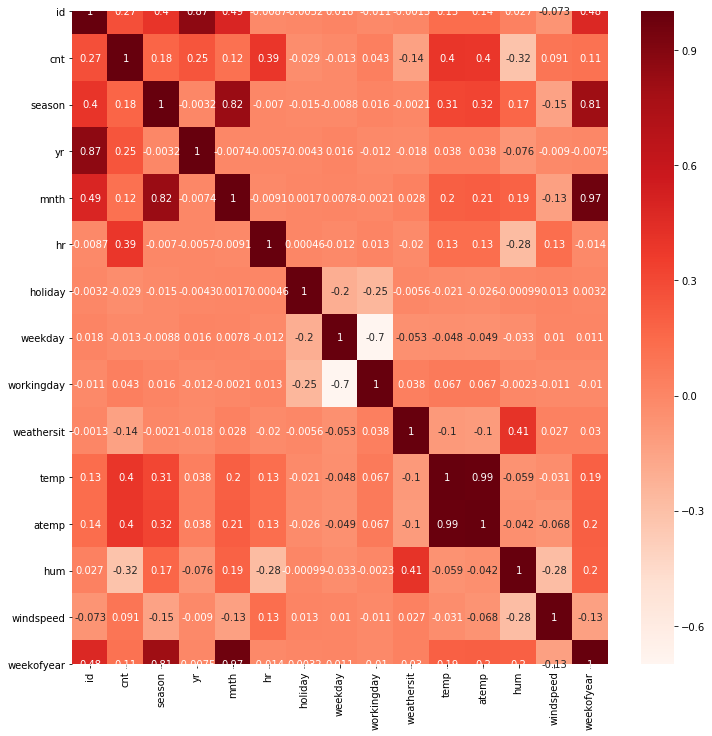

In [52]:
plt.figure(figsize=(12,12))
cor = bike.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

## Creating feature and target arrays

### Icreasing performance for all techniques but RF by dropping workingday, temp (and mnth) 

In [7]:
bike_dropped = bike.drop(['id', 'workingday', 'temp', 'mnth'], axis = 1)
#bike_dropped = bike

In [8]:
X = bike_dropped.drop('cnt', axis = 1).values
y = bike_dropped['cnt'].values

## Creating train and test data 


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

## Starting with a simple model to:
+ get a sense of how challenging the problem is
+ many more things might go wrong with complex models
+ how much signal can we pull out using basic models

## Ridge regression
__Score history:__
- Test set RMSE of rf: 137.47 (ordinal date)
- Test set RMSE of rf: 137.44 (dayofweek, ...)
- Test set RMSE of rf: 136.08 (parameter tuning)
- Test set RMSE of rf: 135.898 (remove workingday, temp(, mnth))

### Ridge parameters
- __alpha:__
    - regularization strenght: the higher the value, the stronger the regularization
- __fit_intercept:__
    - weather to calculate an intercept for this model (e. g. not needed if centered) 
- __normalize:__
    - if `fit_intercept` and `normalize` are both `True` the regressor X will be normalized

In [117]:
from sklearn.linear_model import Ridge

In [118]:
# create parameter list for ridge regression
params_ridge = {
    'alpha':[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 
    #[x/100. for x in range(0,100,1)],
    'normalize': [True, False],
    'fit_intercept': [True]
}

ridge = Ridge()

In [119]:
# setup cross validation parameter grid search
grid_ridge = GridSearchCV(estimator=ridge,
    param_grid=params_ridge,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1)

In [120]:
# fitting model on training data
grid_ridge.fit(X_train, y_train)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    0.3s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
                         'fit_intercept': [True], 'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=1)

In [121]:
# extracting best parameters (can be used for finer hyper parameter tuning)
grid_ridge.best_params_

{'alpha': 0.5, 'fit_intercept': True, 'normalize': False}

In [122]:
# predicting values and calculating the rmse-score
y_pred_ridge = grid_ridge.predict(X_test)
rmse_test_lasso = MSE(y_test, y_pred_ridge)**(1/2)
print('Test set RMSE of rf: {:.2f}'.format(rmse_test_lasso))

Test set RMSE of rf: 135.90


In [123]:
print_metrics(y_pred_ridge, y_test)

,MAE,MAPE,RMSE,R2
0,102.56,3.2412,135.9,0.39


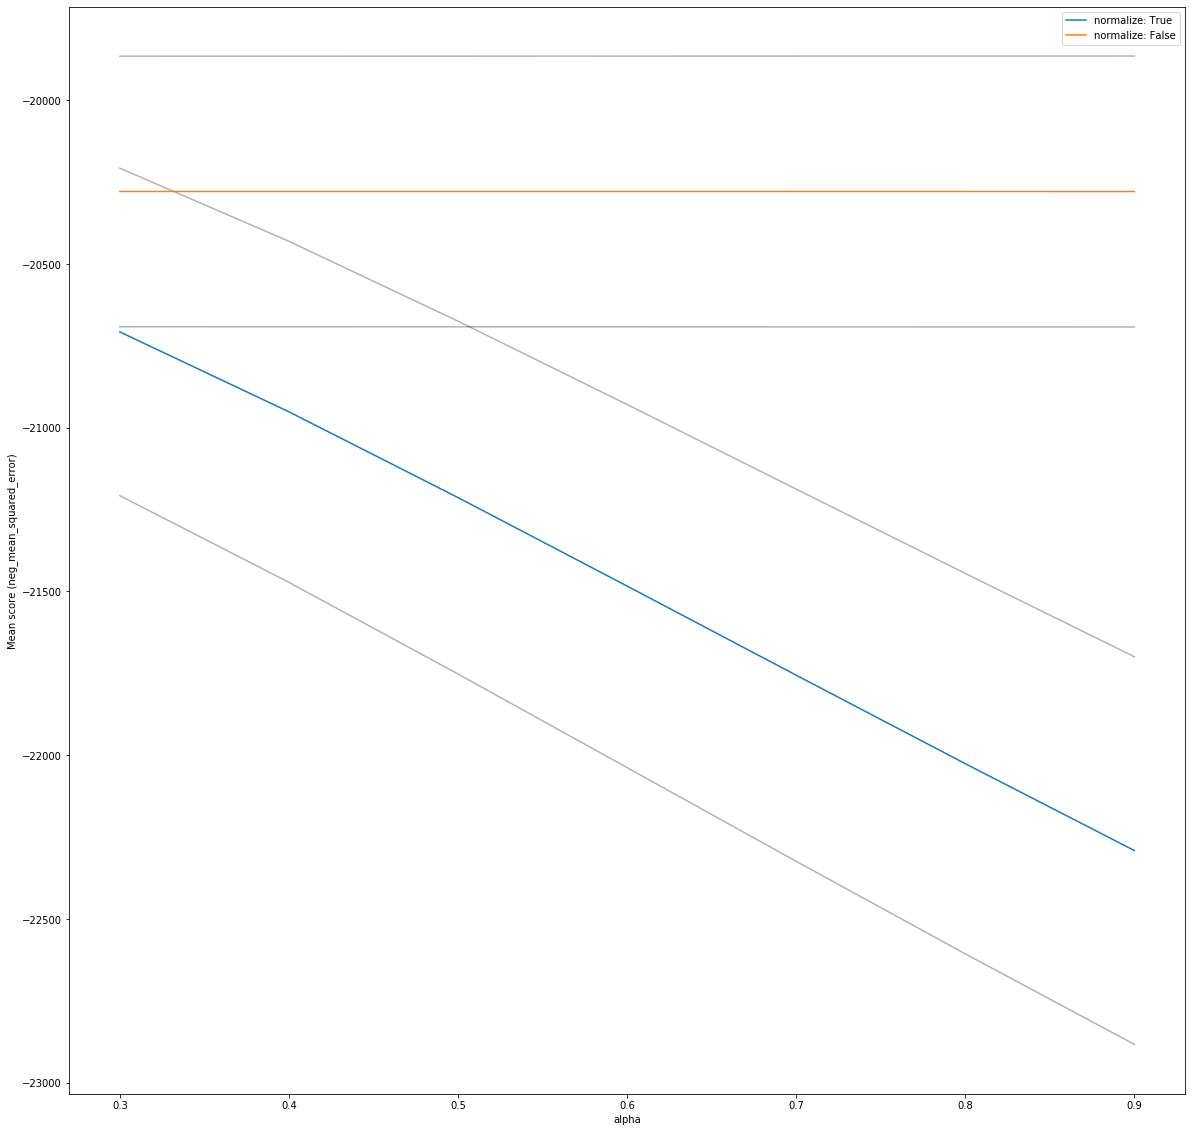

In [128]:
params = params_ridge
grid = grid_ridge
param1_name = 'normalize'
param2_name = 'alpha'
param1 = params[param1_name]
param2 = params[param2_name]

scores_df = pd.DataFrame(grid.cv_results_)

scores_mean = [x for x in scores_df['mean_test_score']]
scores_mean = np.array(scores_mean).reshape(len(param2), len(param1))
scores_mean = np.swapaxes(scores_mean,0,1)
scores_std = [x for x in scores_df['std_test_score']]
scores_std = np.array(scores_std).reshape(len(param2), len(param1))
scores_std = np.swapaxes(scores_std,0,1)

plt.figure(figsize=(20, 20))
for ind, i in enumerate(param1):
    plt.plot(param2, scores_mean[ind], label=param1_name+': ' + str(i))
    plt.plot(param2, scores_mean[ind] + scores_std[ind], color='black', alpha=0.3)
    plt.plot(param2, scores_mean[ind] - scores_std[ind], color='black', alpha=0.3)
plt.legend()
plt.xlabel(param2_name)
plt.ylabel('Mean score (neg_mean_squared_error)')
plt.show()

## Lasso regression
__Score history:__
- Test set RMSE of rf: 136.00
- Test set RMSE of rf: 135.90 (remove workingday, temp(, mnth))

### Lasso Parameters:
- __alpha:__
    - constant that multiplies the L1-Norm
- __fit_intercept:__
    - weather to calculate an intercept for this model (e. g. not needed if centered) 
- __normalize:__
    - if `fit_intercept` and `normalize` are both `True` the regressor X will be normalized
- __positive:__
    - when `True` forces the coefficients to be positive

In [110]:
from sklearn.linear_model import Lasso

In [111]:
params_lasso = {
    'alpha': [0.001, 0.005, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2],
    'normalize': [True, False],
    'fit_intercept': [ False],
    'positive': [ False] 
}

lasso = Lasso()

In [112]:
grid_lasso = GridSearchCV(estimator=lasso,
    param_grid=params_lasso,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1)

In [113]:
grid_lasso.fit(X_train, y_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    1.4s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.001, 0.005, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                   0.7, 0.8, 0.9, 1, 1.1, 1.2],
                         'fit_intercept': [False], 'normalize': [True, False],
                         'positive': [False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=1)

In [114]:
grid_lasso.best_params_

{'alpha': 0.001, 'fit_intercept': False, 'normalize': True, 'positive': False}

In [115]:
y_pred_lasso = grid_lasso.predict(X_test)
rmse_test_lasso = MSE(y_test, y_pred_lasso)**(1/2)
print('Test set RMSE of rf: {:.2f}'.format(rmse_test_lasso))

Test set RMSE of rf: 135.94


In [69]:
print_metrics(y_pred_lasso, y_test)

,MAE,MAPE,RMSE,R2
0,102.57,3.2418,135.9,0.39


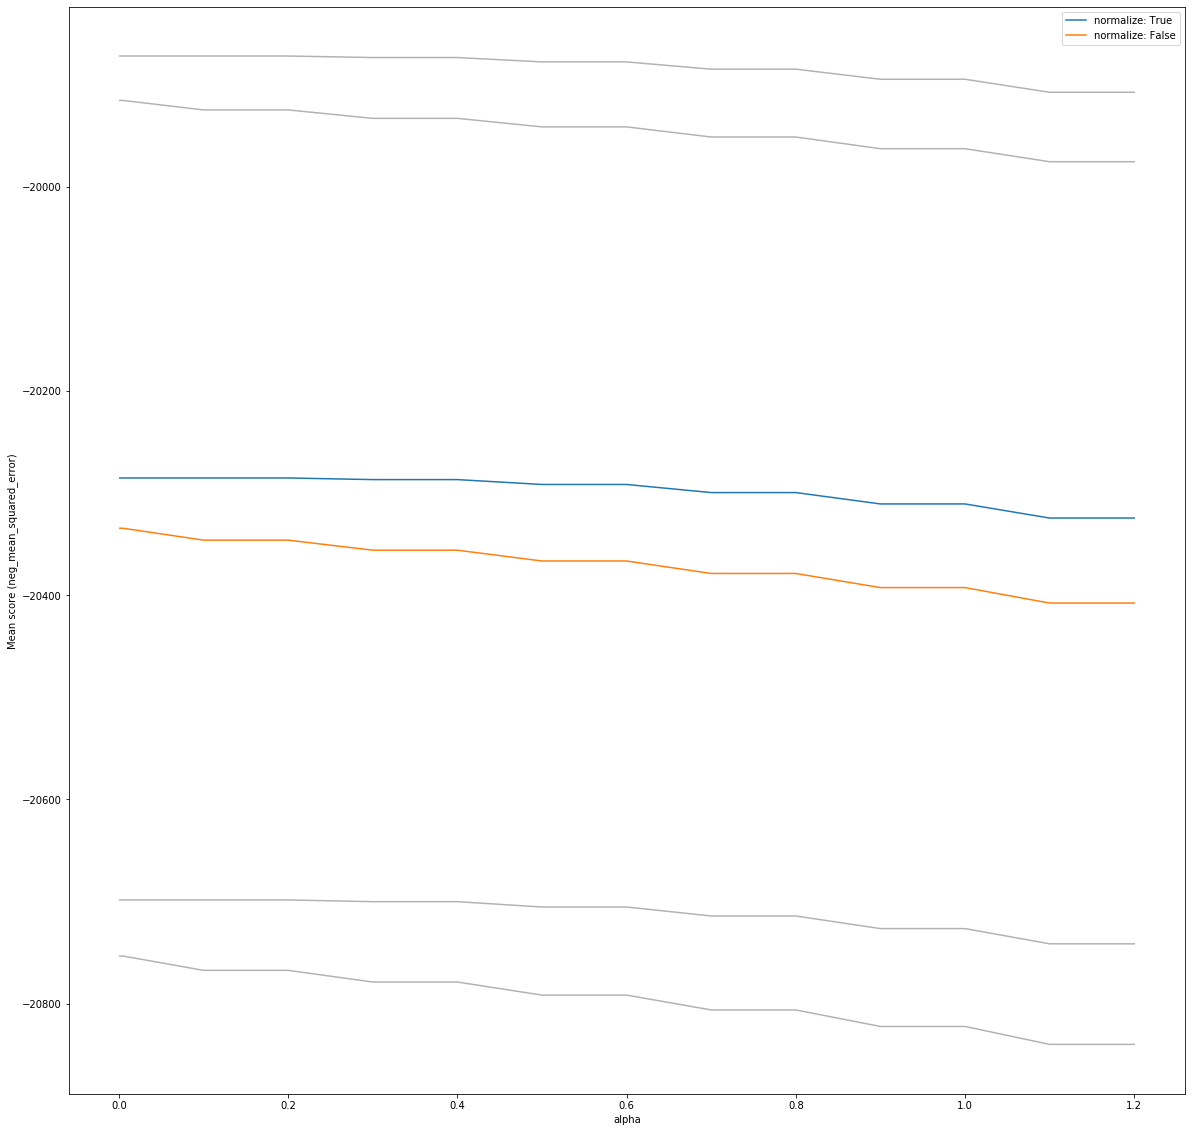

In [136]:
params = params_lasso
grid = grid_lasso
param1_name = 'alpha'
param2_name = 'normalize'
param1 = params[param1_name]
param2 = params[param2_name]

scores_df = pd.DataFrame(grid.cv_results_)

scores_mean = [x for x in scores_df['mean_test_score']]
scores_mean = np.array(scores_mean).reshape(len(param2), len(param1))
#scores_mean = np.swapaxes(scores_mean,0,1)
scores_std = [x for x in scores_df['std_test_score']]
scores_std = np.array(scores_std).reshape(len(param2), len(param1))
#scores_std = np.swapaxes(scores_std,0,1)

plt.figure(figsize=(20, 20))
for ind, i in enumerate(param2):
    plt.plot(param1, scores_mean[ind], label=param2_name+': ' + str(i))
    plt.plot(param1, scores_mean[ind] + scores_std[ind], color='black', alpha=0.3)
    plt.plot(param1, scores_mean[ind] - scores_std[ind], color='black', alpha=0.3)
plt.legend()
plt.xlabel(param1_name)
plt.ylabel('Mean score (neg_mean_squared_error)')
plt.show()

## Random Forest
__Score history:__
- Test set RMSE of rf: 112.39
- Test set RMSE of rf: 107.32 (start parameter tuning)
- Test set RMSE of rf: 106.62 (parameter tuning 2)
- Test set RMSE of rf: 71.72 (pt 3)
- Test set RMSE of rf: 70.43 (new date, higher estimators)
- Test set RMSE of rf: 41.65 (pt 4)
- Test set RMSE of rf: 41.53 (pt 5

### Random Forest parameters
- __n_estimators:__
    - number of trees in the forest
- __max_depth:__
    - maximum depth of the tree
- __min_samples_split:__
    - the min. number of samples required to split an internal node
- __min_samples_leaf:__
    - the minimum number of samples required to be at a leaf node
- __min_weight_fraction_leaf:__
    - the minimum weighted fraction of the sum total of weights
- __max_features:__
    - the number of features to consider when looking for the best split
- __min_impurity_decrease:__
    - A node will be split if this split induces a decrease of the impurity greater than or equal to this value.

In [88]:
from sklearn.ensemble import RandomForestRegressor

In [89]:
rf = RandomForestRegressor(random_state=42)

In [90]:
# take a look at the rf's parameters
print(rf.get_params())

{'bootstrap': True, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 'warn', 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [100]:
params_rf = {
    'n_estimators': [200],
    'max_depth': [None, 20, 21, 22, 25, 30],
    'min_samples_split': [2, 3, 4]
}

grid_rf = GridSearchCV(estimator=rf,
    param_grid=params_rf,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1)

In [101]:
grid_rf.fit(X_train, y_train)


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  2.6min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [None, 20, 21, 22, 25,

In [102]:
grid_rf.best_params_

{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}

In [103]:
y_pred = grid_rf.predict(X_test)
rmse_test = MSE(y_test, y_pred)**(1/2)
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))


Test set RMSE of rf: 45.17


In [77]:
print_metrics(y_pred, y_test)

,MAE,MAPE,RMSE,R2
0,27.84,0.3716,45.38,0.93


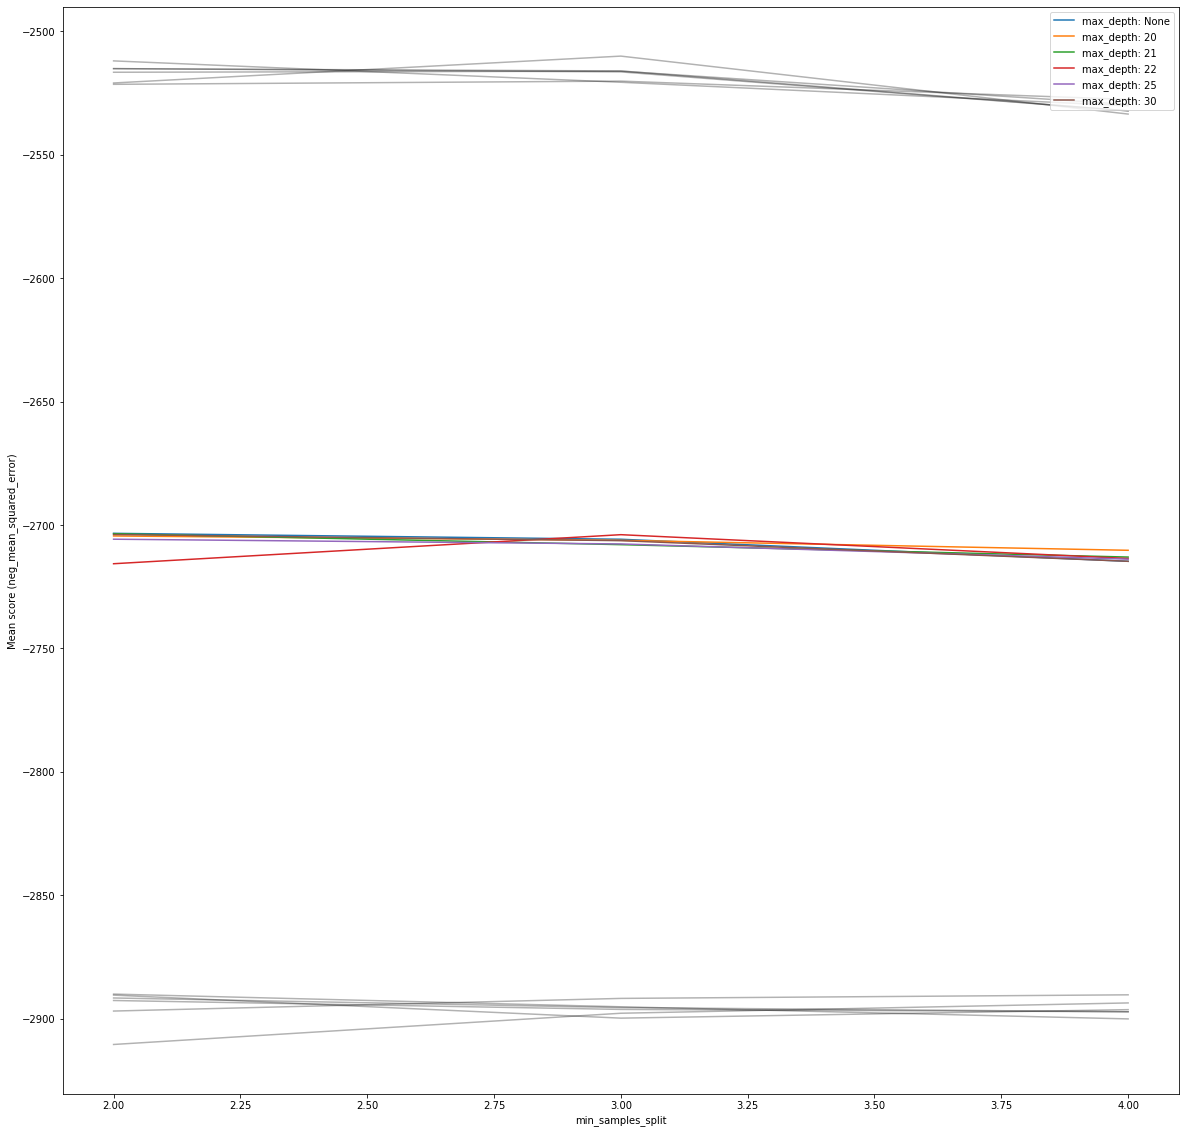

In [109]:
params = params_rf
grid = grid_rf
param1_name = 'max_depth'
param2_name = 'min_samples_split'
param1 = params[param1_name]
param2 = params[param2_name]

scores_df = pd.DataFrame(grid.cv_results_)

scores_mean = [x for x in scores_df['mean_test_score']]
scores_mean = np.array(scores_mean).reshape(len(param1), len(param2))
#scores_mean = np.swapaxes(scores_mean,0,1)
scores_std = [x for x in scores_df['std_test_score']]
scores_std = np.array(scores_std).reshape(len(param1), len(param2))
#scores_std = np.swapaxes(scores_std,0,1)

plt.figure(figsize=(20, 20))
for ind, i in enumerate(param1):
    plt.plot(param2, scores_mean[ind], label=param1_name+': ' + str(i))
    plt.plot(param2, scores_mean[ind] + scores_std[ind], color='black', alpha=0.3)
    plt.plot(param2, scores_mean[ind] - scores_std[ind], color='black', alpha=0.3)
plt.legend()
plt.xlabel(param2_name)
plt.ylabel('Mean score (neg_mean_squared_error)')
plt.show()

## Creating SVM
__Score history:__
- Test set RMSE of rf: 143.46
- Test set RMSE of rf: 140.58(remove workingday, temp(, mnth))

### SVM parameters
- __c:__
    - penalty parameeter (higher => overfitting)
- __shrinking:__
    - weather to use the shrinking heuristic
- __kernel:__
    - specifies the kernel type

In [68]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

In [138]:
scaler = RobustScaler()
svr = SVR()

In [139]:
svr.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'auto_deprecated',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [140]:
pipe = make_pipeline(scaler, svr)

In [141]:
params_svr = {'svr__C': [1.0, 1.1, 1.2, 1.3, 1.4],
 'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
 'svr__shrinking': [True]
             }

grid_svr = GridSearchCV(estimator=pipe,
    param_grid=params_svr,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1)

In [142]:
grid_svr.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/loca

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default 

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('robustscaler',
                                        RobustScaler(copy=True,
                                                     quantile_range=(25.0,
                                                                     75.0),
                                                     with_centering=True,
                                                     with_scaling=True)),
                                       ('svr',
                                        SVR(C=1.0, cache_size=200, coef0=0.0,
                                            degree=3, epsilon=0.1,
                                            gamma='auto_deprecated',
                                            kernel='rbf', max_iter=-1,
                                            shrinking=True, tol=0.001,
                                            verbose=False))],
                   

In [143]:
grid_svr.best_params_

{'svr__C': 1.4, 'svr__kernel': 'linear', 'svr__shrinking': True}

In [84]:
y_pred_svr = grid_svr.predict(X_test)
rmse_test_svr = MSE(y_test, y_pred_svr)**(1/2)
print('Test set RMSE of rf: {:.2f}'.format(rmse_test_svr))


Test set RMSE of rf: 140.58


In [85]:
print_metrics(y_pred_svr, y_test)

,MAE,MAPE,RMSE,R2
0,96.78,2.3632,140.58,0.34


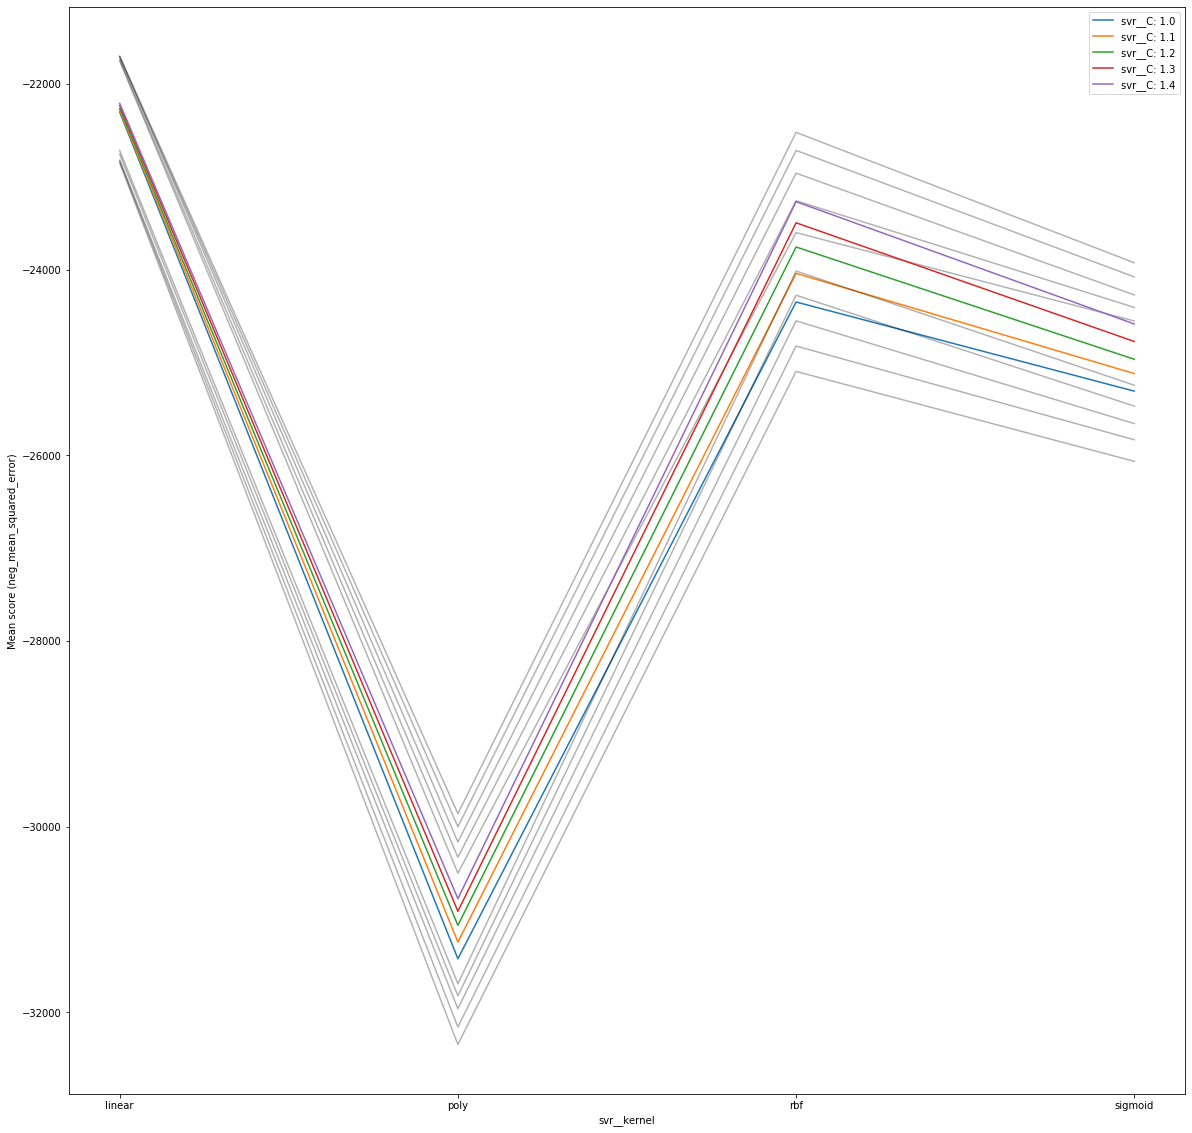

In [144]:
params = params_svr
grid = grid_svr
param1_name = 'svr__kernel'
param2_name = 'svr__C'
param1 = params[param1_name]
param2 = params[param2_name]

scores_df = pd.DataFrame(grid.cv_results_)

scores_mean = [x for x in scores_df['mean_test_score']]
scores_mean = np.array(scores_mean).reshape(len(param2), len(param1))
#scores_mean = np.swapaxes(scores_mean,0,1)
scores_std = [x for x in scores_df['std_test_score']]
scores_std = np.array(scores_std).reshape(len(param2), len(param1))
#scores_std = np.swapaxes(scores_std,0,1)

plt.figure(figsize=(20, 20))
for ind, i in enumerate(param2):
    plt.plot(param1, scores_mean[ind], label=param2_name+': ' + str(i))
    plt.plot(param1, scores_mean[ind] + scores_std[ind], color='black', alpha=0.3)
    plt.plot(param1, scores_mean[ind] - scores_std[ind], color='black', alpha=0.3)
plt.legend()
plt.xlabel(param1_name)
plt.ylabel('Mean score (neg_mean_squared_error)')
plt.show()

## Creating a GradientBoostingRegressor
__Score history:__
- Test set RMSE of rf: 65.32
- Test set RMSE of rf: 44.17 (parameter tuning)
- Test set RMSE of rf: 40.93 (remove workingday, temp(, mnth))

In [10]:
from sklearn.ensemble import GradientBoostingRegressor

In [11]:
gbt = GradientBoostingRegressor(random_state=42)


In [46]:
params_gbt = {
'n_estimators': [400],
'max_depth': [1, 2, 3, 4, 5, 6, 7],
'max_features': ['log2'],
'learning_rate': [0.05, 0.1, 0.15],
'subsample': [0.8]
    
}
# Instantiate 'grid_rf'
grid_gbt = GridSearchCV(estimator=gbt,
param_grid=params_gbt,
cv=3,
scoring='neg_mean_squared_error',
verbose=1,
n_jobs=-1)

In [47]:
grid_gbt.fit(X_train, y_train)

Fitting 3 folds for each of 21 candidates, totalling 63 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:  1.1min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter...
                             

In [48]:
grid_gbt.best_params_

{'learning_rate': 0.1,
 'max_depth': 6,
 'max_features': 'log2',
 'n_estimators': 400,
 'subsample': 0.8}

In [49]:
best_model = grid_gbt.best_estimator_
y_pred_gbt = best_model.predict(X_test)
rmse_test = MSE(y_test, y_pred_gbt)**(1/2)
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))

Test set RMSE of rf: 40.93


In [ ]:
print_metrics(y_pred_gbt, y_test) # mit 1000 est


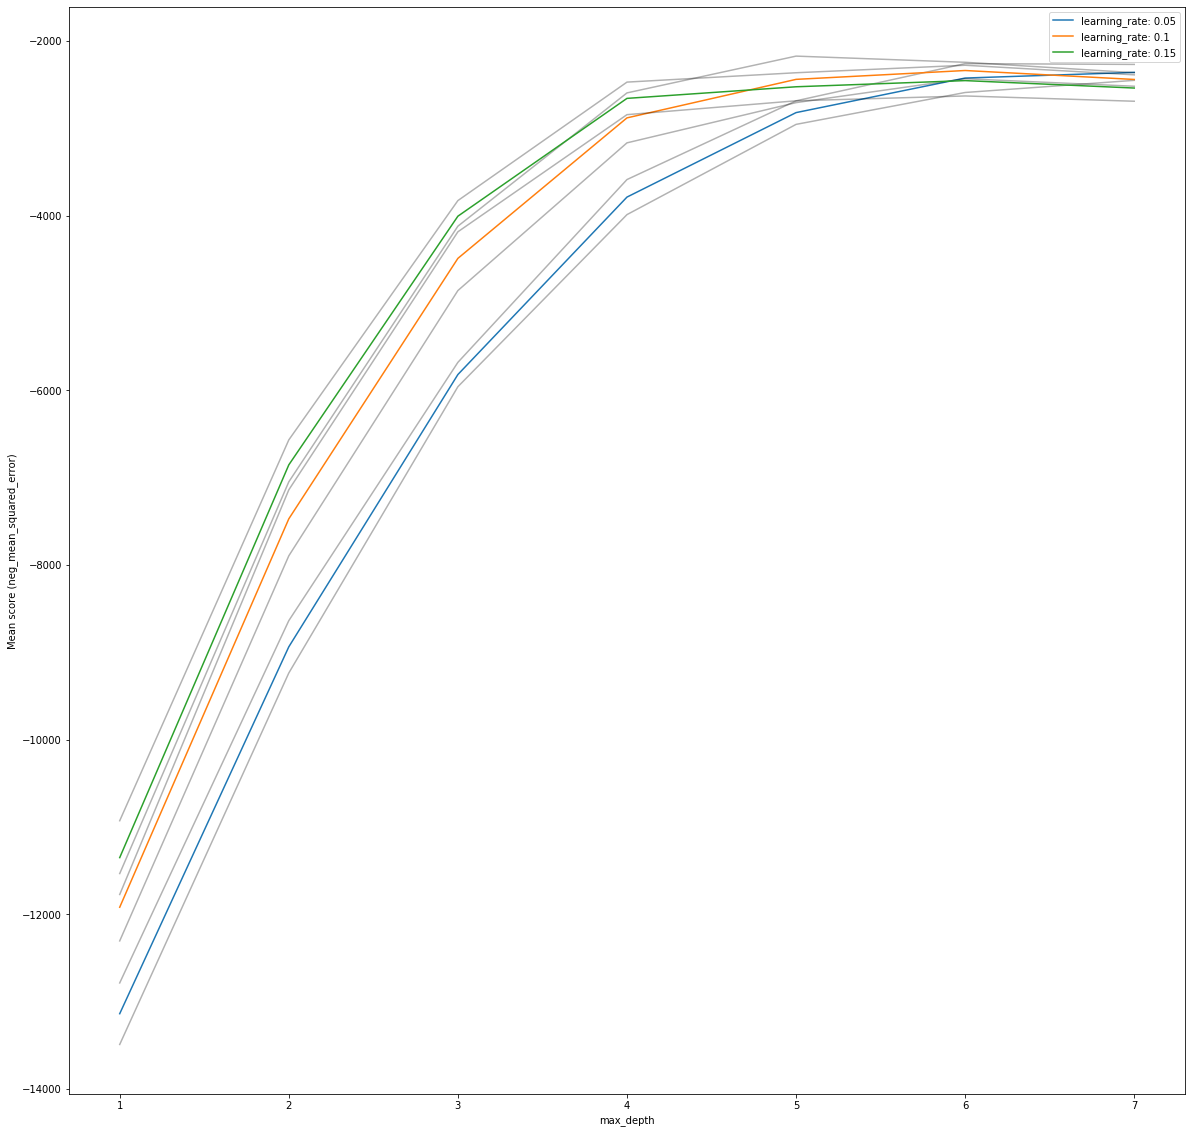

In [77]:
param1_name = 'max_depth'
param2_name = 'learning_rate'
param1 = params_gbt[param1_name]
param2 = params_gbt[param2_name]

scores_df = pd.DataFrame(grid_gbt.cv_results_)

scores_mean = [x for x in scores_df['mean_test_score']]
scores_mean = np.array(scores_mean).reshape(len(param2), len(param1))
#scores_mean = np.swapaxes(scores_mean,0,1)
scores_std = [x for x in scores_df['std_test_score']]
scores_std = np.array(scores_std).reshape(len(param2), len(param1))
#scores_std = np.swapaxes(scores_std,0,1)

plt.figure(figsize=(20, 20))
for ind, i in enumerate(param2):
    plt.plot(param1, scores_mean[ind], label=param2_name+': ' + str(i))
    plt.plot(param1, scores_mean[ind] + scores_std[ind], color='black', alpha=0.3)
    plt.plot(param1, scores_mean[ind] - scores_std[ind], color='black', alpha=0.3)
plt.legend()
plt.xlabel(param1_name)
plt.ylabel('Mean score (neg_mean_squared_error)')
plt.show()